In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

pd.options.display.max_columns = None


In [2]:
df = pd.read_csv('HH.csv', names=list(range(1, 25)))


In [3]:
def solar(lat, tilt, azimuth, albedo, A, B, C, lamda, n, month):
    
    if not n:
        start = 0
        end = 12
    else:
        start = n - 1
        end = n
    
    phi = np.radians(lat)
    beta = np.radians(tilt)
    gamma = np.radians(azimuth)
    
    es=[]
    dec_d = []
    h = np.array(list(np.arange(24)) * (month[end] - month[start]))
    
    for i in range(month[start], month[end]):
        es.append(E(i+1))
        dec_d.append(declination(i+1))

    e = np.repeat(np.array(es), 24)
    omega = (15 * (h+1 + (lamda - 135) / 15 + e / 60) - 180) *  np.pi / 180
    delta = np.repeat(np.array(dec_d), 24)

    # Calculate angle of incidence on tilted surface for every hour of the year
    cos_theta = np.sin(delta) * np.sin(phi) * np.cos(beta) - np.sin(delta) * np.cos(phi) * np.sin(beta) * np.cos(
        gamma) + np.cos(delta) * np.cos(phi) * np.cos(beta) * np.cos(omega) + np.cos(delta) * np.sin(phi) * np.sin(
        beta) * np.cos(gamma) * np.cos(omega) + np.cos(delta) * np.sin(beta) * np.sin(gamma) * np.sin(omega)

    # Calculate zenith angle for every hour of the year
    cos_theta_z = np.cos(phi) * np.cos(delta) * np.cos(omega) + np.sin(phi) * np.sin(delta)

    # Ratio of beam radiation on tilted surface to beam radiation on horizontal surface
    Rb = cos_theta / cos_theta_z
    
    h1 = np.array(list(np.arange(1, 25))* (month[end] - month[start]))
    h2 = np.array(list(np.arange(24))* (month[end] - month[start]))    
    
    
    ts1 = h1 + (lamda - 135) / 15 + e / 60
    ts2 = h2 + (lamda - 135) / 15 + e / 60

    te = 12 - (lamda - 135) / 15 - e / 60-0.5
    
    h_start = (ts2 - te) * np.pi / 12  # Start of hour
    h_end = (ts1 - te) * np.pi / 12
    
    day=np.array(list(np.arange(month[start],month[end]))*24)

    G0c = 12*3600/np.pi*1367*(1+0.033*np.cos(2*np.pi*day/365))*(np.cos(phi)*np.cos(delta)*(np.sin(h_end)-np.sin(h_start))+(h_end-h_start)*np.sin(phi)*np.sin(delta))

    
    f = np.zeros((month[end] - month[start])*24)
    Ai = np.zeros((month[end]- month[start])*24)

    for i in range(month[start], month[end]):
        if A[i] > 0:
            # Horizon brightening factor
            f[i] = np.sqrt(B[i] / A[i])


        if G0c[i-month[start]] > 0:
            # Anisotropy index
            Ai[i] = B[i] / G0c[i-month[start]]
            
    
    Gt = (B+C*Ai) * Rb + C * (1-Ai)*(1 + np.cos(beta)) / 2*(1+f*np.sin(beta/2)**3) + A * albedo * (1 - np.cos(beta)) / 2
    
    
    return Gt


In [4]:
class Count:
    
    def __init__(self):
        self.n = -1
        
    def count(self):
        self.n += 1
        return self.n

In [5]:

def declination(n):
    gama = 2 * np.pi * (n-1) / 365
    delta = (0.006918 - 0.399912 * np.cos(gama) + 0.070257 * np.sin(gama) - 0.006758 * np.cos(
    2 * gama) + 0.000907 * np.sin(2 * gama) - 0.002697 * np.cos(3 * gama) + 0.00148 * np.sin(3 * gama)) # radians
    # delta = -np.arcsin(0.39779 * np.cos(np.radians(0.98565 * (n + 10) + 1.914 * np.sin(np.radians(0.98565 * (n - 2))))))
    return delta

def E(n):
    
#     if n >= 1 & n <= 106:
#         e = -14.2 * np.sin(np.pi * (n+7) / 111)
#     elif n >= 107 & n <= 166:
#         e = 4.0 * np.sin(np.pi * (n-106) / 59)
#     elif n >= 167 & n <= 246:
#         e = -6.5 * np.sin(np.pi*(n-166) / 80)
#     elif n >= 247 & n <= 365:
#         e = 16.4 * np.sin(np.pi * (n-247) / 113)
    
#     B = 2 * np.pi * (n - 81) / 364
#     e = 9.87 * np.sin(2 * B) - 7.53 * np.cos(B) - 1.5 * np.sin(B)  # min
    
    gama = 2 * np.pi * (n-1) / 365
    e = (0.000075+0.001868*np.cos(gama)-0.032077*np.sin(gama)-0.014615*np.cos(2*gama)-0.04089*np.sin(2*gama))*229.18
    
    
    return e


In [6]:
def choice_month(df, n):
    """
    0 代表全部月份
    1, 2, 3, , , 12 代表想要查看的月份
    """
    H = df.iloc[pd.Index([9 * i for i in range(365)])]  # 平射
    Hb = df.iloc[pd.Index([(9 * i + 1) for i in range(365)])]  # 直射
    Hd = df.iloc[pd.Index([(9 * i + 2) for i in range(365)])]  # 散乱
    St = df.iloc[pd.Index([(9 * i + 3) for i in range(365)])]  # sun time
    
    H.loc[:, 'n'] = list(range(365))
    Hb.loc[:, 'n'] = list(range(365))
    Hd.loc[:, 'n'] = list(range(365))
    St.loc[:, 'n'] = list(range(365))

    H.set_index('n', inplace=True)
    Hb.set_index('n', inplace=True)
    Hd.set_index('n', inplace=True)
    St.set_index('n', inplace=True)

    month = np.array([0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]).cumsum()
    H_sum = H.sum(axis=1)
    
#     Hb_sum = Hb.sum(axis=1)
#     Hd_sum = Hd.sum(axis=1)

    for i in range(len(month) - 1):
        tmp = H_sum[month[i]: month[i + 1]].sort_values()[:0].index
        with pd.option_context('mode.chained_assignment', None):
            H.loc[tmp, :] = 0
            Hb.loc[tmp, :] = 0
            Hd.loc[tmp, :] = 0
            St.loc[tmp, :] = 0
    
    if n:
        start = month[n - 1]
        end = month[n]
    else:
        start = 0
        end = 365
    
    
    H = H.iloc[pd.Index([i for i in range(start, end)])]  # 平射
    Hb = Hb.iloc[pd.Index([(i) for i in range(start, end)])]  # 直射
    Hd = Hd.iloc[pd.Index([(i) for i in range(start, end)])]  # 散乱
    St = St.iloc[pd.Index([(i) for i in range(start, end)])]  # sun time

    H = np.array(H).ravel()
    Hb = np.array(Hb).ravel()
    Hd = np.array(Hd).ravel()
    St = np.array(St).ravel()

    df = pd.DataFrame(np.array([H, Hb, Hd]).T, columns=['平射', '直射', '散乱'])

    df['平射'] = df['平射'] * 0.01 * 10 ** 6 / 3600
    df['直射'] = df['直射'] * 0.01 * 10 ** 6 / 3600
    df['散乱'] = df['散乱'] * 0.01 * 10 ** 6 / 3600
    
    A = df['平射']
    B = df['直射']
    C = df['散乱']
    
    PHI = 26.207 # latitude
    lamda = 127.685 # longitude




#     PHI=31.5
#     lamda=130.5
    
    lat = PHI
    albedo = 0.2
    
    
    
    azimuth = 0
    azimuth_end = 360
    azimuth_range = azimuth_end - azimuth

    tilt = 0
    tilt_end = 90
    
    count = Count()
    for i in range(azimuth, azimuth_end + 1):
        Solar_radiation_year = []
        for tilt in range(tilt_end + 1):
            df[str(count.count())] = solar(lat, tilt, i, albedo, A, B, C, lamda, n, month)
        print(i, end=' ')
    print()
    
    test = df.iloc[:, 3:].agg(['sum'])
    z = np.array(test).reshape((361, 91)) / 100000

    X = np.arange(0, 361, 1)  # Azimuth
    Y = np.arange(0, tilt_end + 1, 1)  # Tilt_angle
    X, Y = np.meshgrid(X, Y)

    fig = plt.figure(figsize=(10, 10))
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 15
    ax = Axes3D(fig)
    ax.plot_surface(X, Y, z[X, Y], cmap=mpl.cm.coolwarm)

    ax.set_xlabel(r"Azimuth $A_a$ [°]", fontsize=18)
    ax.set_ylabel(r"Tilt angle $\beta$ [°]", fontsize=18)
    ax.set_zlabel(r"Generated energy $P_{pv}$ [MWh]", fontsize=18)

    plt.title("Solar", fontsize=18)
    print(f'''Ppv_max: {z[np.where(z==z.max())[0],np.where(z==z.max())[1]] / 1000000},
        Azimuth: {np.where(z==z.max())[0]},
        Tilt: {np.where(z==z.max())[1]}''')
    

D:\Anaconda3-5.1.0\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\Anaconda3-5.1.0\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

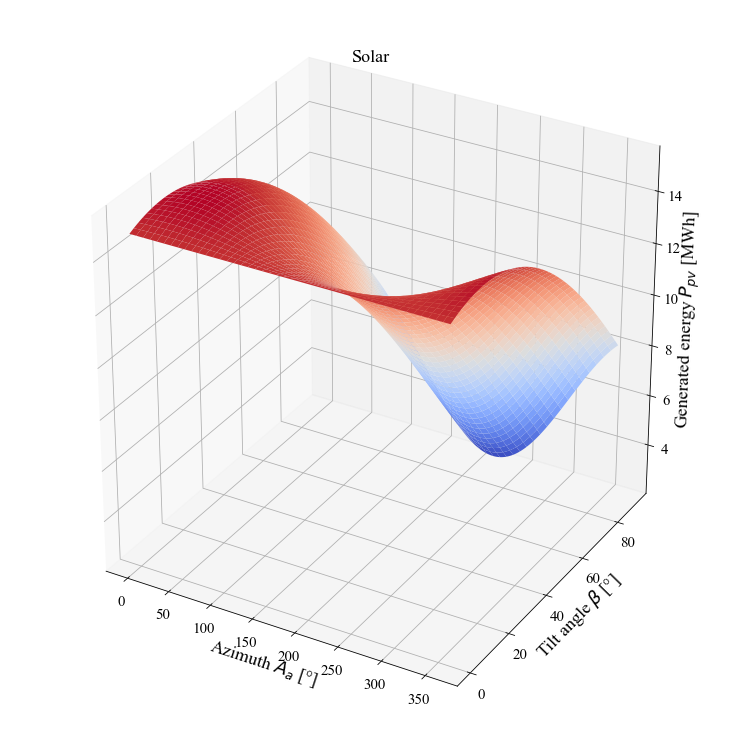

In [7]:
choice_month(df, 0)